<a href="https://colab.research.google.com/github/HimankSehgal/Semantic_Segmentation_With_U-Net/blob/main/UNet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation on Helen Dataset

# Steps followed

1. Importing necessary libraries
2. Looking at directory structure and making desired shiftings
3. Data Preprocessing
4. Defining Train and Test Dataloaders
5. Defining model
6. Defining Dice Loss and optimizer
7. Performing Forward Propagation
8. Visualizing predictions
9. Predictions on test set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1. Importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.utils import make_grid


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import PIL
from PIL import Image
import warnings

from tqdm import tqdm

import shutil


In [ ]:
os.chdir('/content/drive/MyDrive/Datasets')
os.getcwd()

'/content/drive/MyDrive/Datasets'

## Step 2. Looking at directory structure

### a) Image files directory tree
<pre>.
└── helenstar_release
     ├── train
     │   ├── image.jpg
     │   ├── label.png
     ├   ├── viz.jpg
     │   └── ... (1999 sets of 3 images i.e 5997 images total)           
     └── test
         ├── image.jpg
         ├── label.png`
         ├── viz.jpg
         └── ... (100 sets of 3 images i.e 300 images total)</pre>


### b) Perform necessary shiftings

In [ ]:
train_images = []
train_labels = []
for file in tqdm(os.listdir(os.path.join(os.getcwd() ,'helenstar_release/train'))):
    
    if "image" in file:
        train_images.append(os.path.join(os.getcwd() ,'helenstar_release/train', file))
    elif "label" in file:
        train_labels.append(os.path.join(os.getcwd() ,'helenstar_release/train', file))


In [ ]:
test_images = []
test_labels = []
for file in tqdm(os.listdir(os.path.join(os.getcwd() ,'helenstar_release/test'))):
    
    if "image" in file:
        test_images.append(os.path.join(os.getcwd() ,'helenstar_release/test', file))
    elif "label" in file:
        test_labels.append(os.path.join(os.getcwd() ,'helenstar_release/test', file))


In [ ]:
for train_image in train_images:
    shutil.copy(train_image , os.path.join(os.getcwd() , 'splitted_data/train/images/'))
    
for train_label in train_labels:
    shutil.copy(train_label , os.path.join(os.getcwd() , 'splitted_data/train/labels/'))
    
for test_image in test_images:
    shutil.copy(test_image , os.path.join(os.getcwd() , 'splitted_data/test/images/'))
    
for test_label in test_labels:
    shutil.copy(test_label , os.path.join(os.getcwd() , 'splitted_data/test/labels/'))
    
    

### c) New directory structure

<pre>.
└── splitted_Data
        ├── train
        │   ├── images
        │   │   ├── image1.jpg
        │   │   ├── image2.jpg
        │   │   └── ... (1999 files)
        │   └── labels
        │       ├── label1.jpg
        │       ├── label2.jpg
        │       └── ... (1999 files)       
        │           
        └── test
            ├── images
            │   ├── image1.jpg
            │   ├── image2.jpg
            │   └── ... (100 files)
            └── labels
                ├── label1.jpg
                ├── label2.jpg
                └── ... (100 files)</pre>

# Step 3. Data Preprocessing

In [ ]:
def one_hot(arr):
    
    arr = torch.from_numpy(arr)
    one_hot=F.one_hot(arr.to(torch.int64),num_classes=11)
    return np.transpose(np.array(one_hot),(2,0,1)) 

In [ ]:
class HelenDataset(Dataset):
    def __init__(self, label_dir, img_dir):
        self.img_list=os.listdir(img_dir)
        self.label_list=os.listdir(label_dir)
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.label_list.sort()
        self.img_list.sort()
        #print(self.label_list)
        #print(self.img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_path)
        image = image.resize((256,256), resample=PIL.Image.BICUBIC)

        image = np.array(image)/255
        image = np.transpose(image,(2,0,1))
        image = torch.tensor(image, dtype=torch.float32, requires_grad=False)

        label_path = os.path.join(self.label_dir, self.label_list[idx])
        label = Image.open(label_path)
        label = label.resize((256,256), resample=PIL.Image.NEAREST)

        label = np.array(label)
        label = one_hot(label)

        label = torch.tensor(label, dtype=torch.float32, requires_grad=False)

        sample = [image, label]
        return sample

## Step 4. Defining Train and Test Dataloaders

In [ ]:
curr_dir = os.getcwd()


train_label_path= os.path.join(curr_dir,"splitted_data", "data/train/labels")
train_image_path= os.path.join(curr_dir,"splitted_data", "data/train/images")

training_data = HelenDataset(label_dir=train_label_path, img_dir=train_image_path)

test_label_path= os.path.join(curr_dir, "splitted_data", "data/test/labels")
test_image_path= os.path.join(curr_dir, "splitted_data", "data/test/images")

test_data = HelenDataset(label_dir=test_label_path, img_dir=test_image_path)


In [ ]:
batch_size = 10
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

In [ ]:
for images,labels in train_dataloader:
  break

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([10, 3, 256, 256])
torch.Size([10, 11, 256, 256])


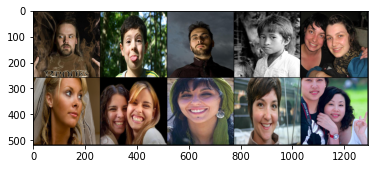

In [ ]:
im = make_grid(images , nrow = 5)
plt.imshow(np.transpose(im , (1,2,0)))

# Step 5. Defining model


In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1 ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""
    
    def __init__(self,in_channels,out_channels):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, from_up , from_skip):
        
        from_up = self.up(from_up)
        size_up = from_up.size()[2]
        size_skip = from_skip.size()[2]
        
        diff = size_skip - size_up
        
        from_up = F.pad( from_up , [diff//2 , diff - diff//2 ,
                                   diff//2 , diff - diff//2])
        
        x = torch.cat([from_skip , from_up ] , dim = 1)
        
        return self.conv(x)
        

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, n_channels = 3 , n_classes = 11):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256 )
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        
        
    def forward(self,x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        
        x = nn.Softmax(dim = 1)(x)
        return x

In [ ]:
model = UNet()

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.05, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.05, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.05, inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), st

In [ ]:
#!pip install torchsummary
from torchsummary import summary
summary(model, (3, 256, 256) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
        LeakyReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        LeakyReLU-14        [-1, 128, 1

In [ ]:
pred = model.forward(images.cuda())
pred.shape

torch.Size([10, 11, 256, 256])

In [ ]:
model.load_state_dict(torch.load("MyModel5.pt"))

<All keys matched successfully>

# Step 6. Dice Loss and Optimizer

In [ ]:
class DiceLoss(nn.Module):
    
    def __init__(self , channels = 11 , eps = 1e-7 ):
        super(DiceLoss,self).__init__()        
        self.channels = channels
        self.eps = eps
        
        
    def forward(self , predicted , target):
        
        mul = predicted * target
        num = torch.sum(mul , dim=(2,3))
        den = 0.7*torch.sum(predicted , dim = (2,3)) + 0.3*torch.sum(target, dim=(2,3)) + self.eps
        loss = torch.sum( 1 - torch.div(num,den))
        return loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

# Step 7. Performing Forward Propagation

In [ ]:
epochs = 20
running_loss = 10*11
training_losses = []
for epochs in tqdm(range(epochs)):
  for b , (images,labels) in enumerate(train_dataloader):
    
    images=images.to(device)
    labels=labels.to(device)
    preds = model(images)               
    loss = DiceLoss().forward(preds, labels)

    optimizer.zero_grad() #set gradients 0
    loss.backward() #calculate gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01, norm_type=2.0)
    optimizer.step() #update weights

    if b % 20 == 1:
      print("mini_batch_ ", b , "   loss ",loss)
      training_losses.append(loss)

    del images
    del labels

  torch.save(model.state_dict(), '/content/drive/MyDrive/Datasets/MyModel5.pt')



# Step 8. Visualizing predictions

In [ ]:
preds = model(images.cuda())

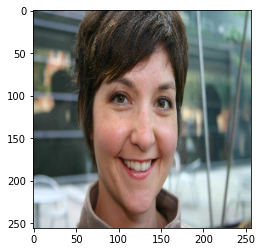

In [ ]:
plt.imshow(np.transpose(images[8] , (1,2,0)))

#plt.savefig('image3.png')

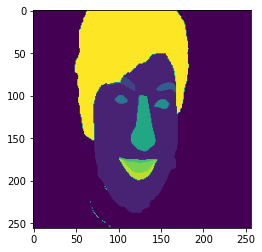

In [ ]:
plt.imshow(torch.argmax(labels , dim=1)[8])
#plt.savefig('label3.png')

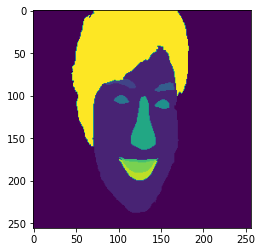

In [ ]:
plt.imshow(torch.argmax(preds.cpu() , dim=1)[8])
#plt.savefig('pred3.png')

# Step 9. Predictions on test set

In [ ]:
test_imgpath=os.path.join(curr_dir,"splitted_data",'test/images')
test_labelpath=os.path.join(curr_dir,"splitted_data",'test/labels')
test_predpath=os.path.join(curr_dir,"splitted_data",'test/preds')

test_imglist=os.listdir(os.path.join(curr_dir,"splitted_data",'test/images'))
test_labellist=os.listdir(os.path.join(curr_dir,"splitted_data",'test/labels'))

In [ ]:
test_imglist.sort()
test_labellist.sort()


In [ ]:
for i in range(len(test_labellist)):
  img=Image.open(os.path.join(test_imgpath, test_imglist[i]))
  img=np.array(img)
  img=np.transpose(img,(2,0,1))
  img_tensor=torch.tensor(img,dtype=torch.float32)
  img_tensor=img_tensor.unsqueeze(0)

  label=Image.open(os.path.join(test_labelpath, test_labellist[i]))
  label=np.array(label)
  label_tensor=torch.tensor(label,dtype=torch.float32)
  label_tensor=label_tensor.unsqueeze(0)

  pred=model(img_tensor.to(device))

  pred=np.array(pred.clone().detach().cpu())
  pred=np.argmax(pred[0] , axis=0)
  pred=pred.astype(np.uint8)

  pred=Image.fromarray(pred)
  pred=pred.save(os.path.join(test_predpath, test_labellist[i]))

In [ ]:
!python3 /content/drive/MyDrive/Datasets/splitted_data/f1_score.py "/content/drive/MyDrive/Datasets/splitted_data/test/labels" "/content/drive/MyDrive/Datasets/splitted_data/test/preds" "/content/drive/MyDrive/Datasets/splitted_data/label_names.txt"

100% 100/100 [00:00<00:00, 188.48it/s]
{'bg': ([0], [0]), 'face': ([1], [1]), 'lb': ([2], [2]), 'rb': ([3], [3]), 'le': ([4], [4]), 're': ([5], [5]), 'nose': ([6], [6]), 'ulip': ([7], [7]), 'imouth': ([8], [8]), 'llip': ([9], [9]), 'hair': ([10], [10]), 'eyes': ([4, 5], [4, 5]), 'brows': ([2, 3], [2, 3]), 'mouth': ([7, 8, 9], [7, 8, 9]), 'overall': ([4, 5, 2, 3, 6, 7, 8, 9], [4, 5, 2, 3, 6, 7, 8, 9])}
f1_bg=0.9240500079001422
f1_face=0.8405945882784983
f1_lb=0.7005460539872244
f1_rb=0.7301984325496081
f1_le=0.8028062022431744
f1_re=0.8269042316258352
f1_nose=0.8508512952562765
f1_ulip=0.682443588332416
f1_imouth=0.6923525599481529
f1_llip=0.7343509096515572
f1_hair=0.64483539303235
f1_eyes=0.814874300118227
f1_brows=0.7150763307756063
f1_mouth=0.8081917367197281
f1_overall=0.8115612496993813


In [ ]:
for test_images,test_labels in test_dataloader:
  break

In [ ]:
test_pred = model(test_images.cuda())

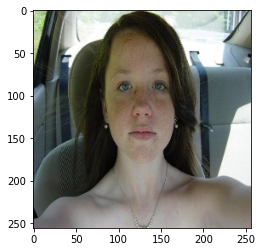

In [ ]:
plt.imshow(np.transpose(test_images[9] , (1,2,0)))

plt.savefig('test_image3.png')

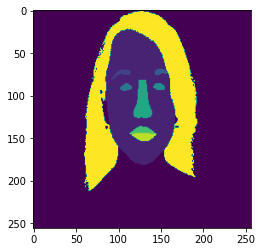

In [ ]:
plt.imshow(torch.argmax(test_labels , dim=1)[9])
plt.savefig('test_label3.png')

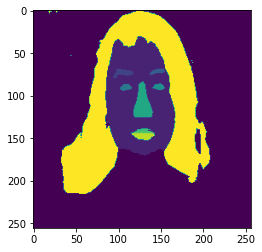

In [ ]:
plt.imshow(torch.argmax(test_pred.cpu() , dim=1)[9])
plt.savefig('test_pred3.png')